# Facebook Prophet을 활용한 시계열 데이터 예측 모델 튜토리얼

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- Facebook Prophet을 활용하여 주가 예측

In [90]:
import warnings
warnings.filterwarnings("ignore")

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr

In [92]:
# 한글 폰트 설정
plt.rc("font", family="Malgun Gothic")

- FDR
    - `Open`:   시가
    - `High`:   고가
    - `Low`:    저가
    - `Close`:  종가
    - `Volume`: 거래량
    - `Change`: 대비

In [93]:
# 삼성전자 종목코드: 005930
samsung = fdr.DataReader("005930")
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-04-05,63700,64000,63400,63900,9176149,0.004717
2023-04-06,63500,63600,62300,62300,14992747,-0.025039
2023-04-07,63800,65200,63800,65000,27476120,0.043339
2023-04-10,64800,66300,64700,65700,18777166,0.010769
2023-04-11,66200,66200,65400,65900,16179016,0.003044


In [94]:
# Apple(AAPL), 애플
apple = fdr.DataReader("AAPL")
apple.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-04,166.600006,166.839996,165.110001,165.630005,165.630005,46278300
2023-04-05,164.740005,165.050003,161.800003,163.759995,163.759995,51511700
2023-04-06,162.429993,164.960007,162.000000,164.660004,164.660004,45390100
2023-04-10,161.419998,162.029999,160.080002,162.029999,162.029999,47672100
2023-04-11,162.350006,162.360001,160.509995,160.979996,160.979996,19920334


In [95]:
# 비트코인 시세
btc = fdr.DataReader("BTC/KRW", "2018-01-01")
btc.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-07,37112976.0,37117132.0,36619020.0,36992692.0,36992692.0,18253290942742
2023-04-08,36985872.0,37072288.0,36606008.0,36759868.0,36759868.0,14297641772215
2023-04-09,36752828.0,37067896.0,36703960.0,36791596.0,36791596.0,12339328544076
2023-04-10,36797616.0,37585124.0,36634528.0,37299024.0,37299024.0,16028194560346
2023-04-11,39176968.0,39956012.0,39127644.0,39956012.0,39956012.0,32686087340032


### 시각화

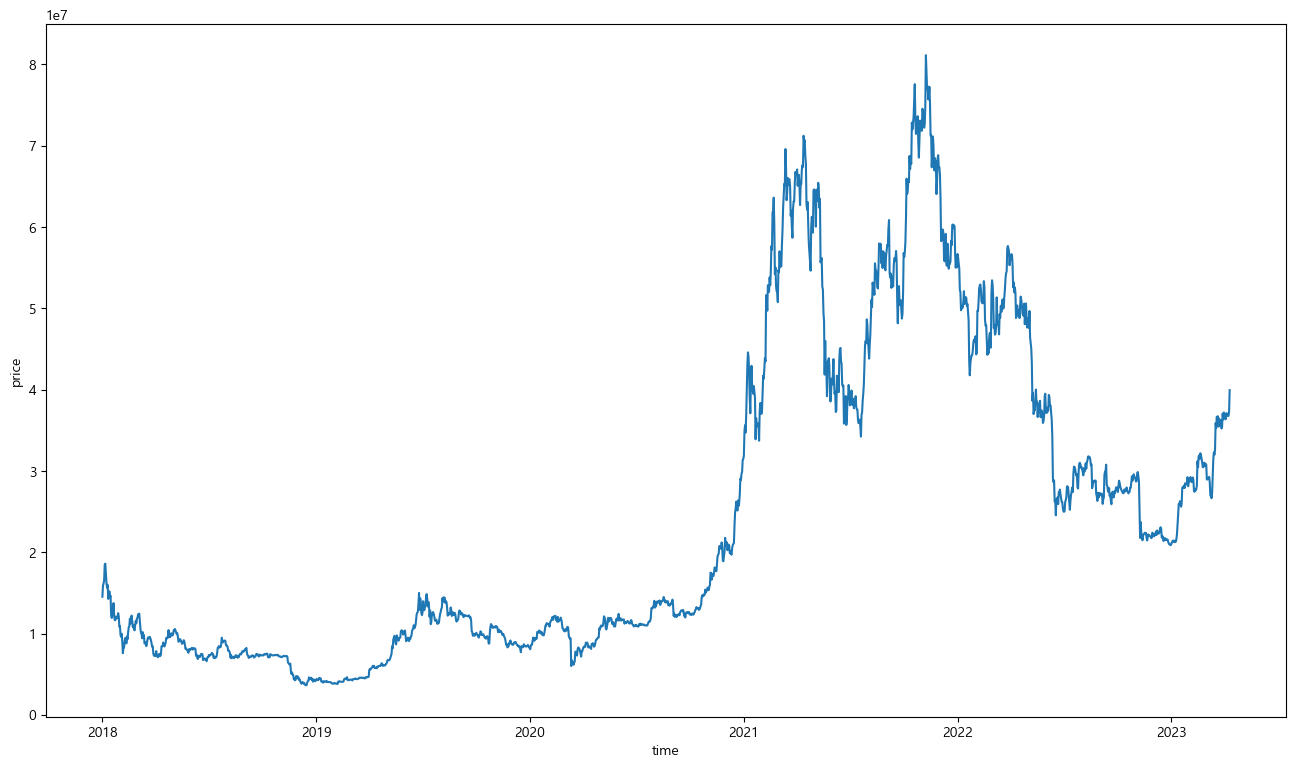

In [96]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=btc.index, y="Close", data=btc)
plt.xlabel("time")
plt.ylabel("price")
plt.show()

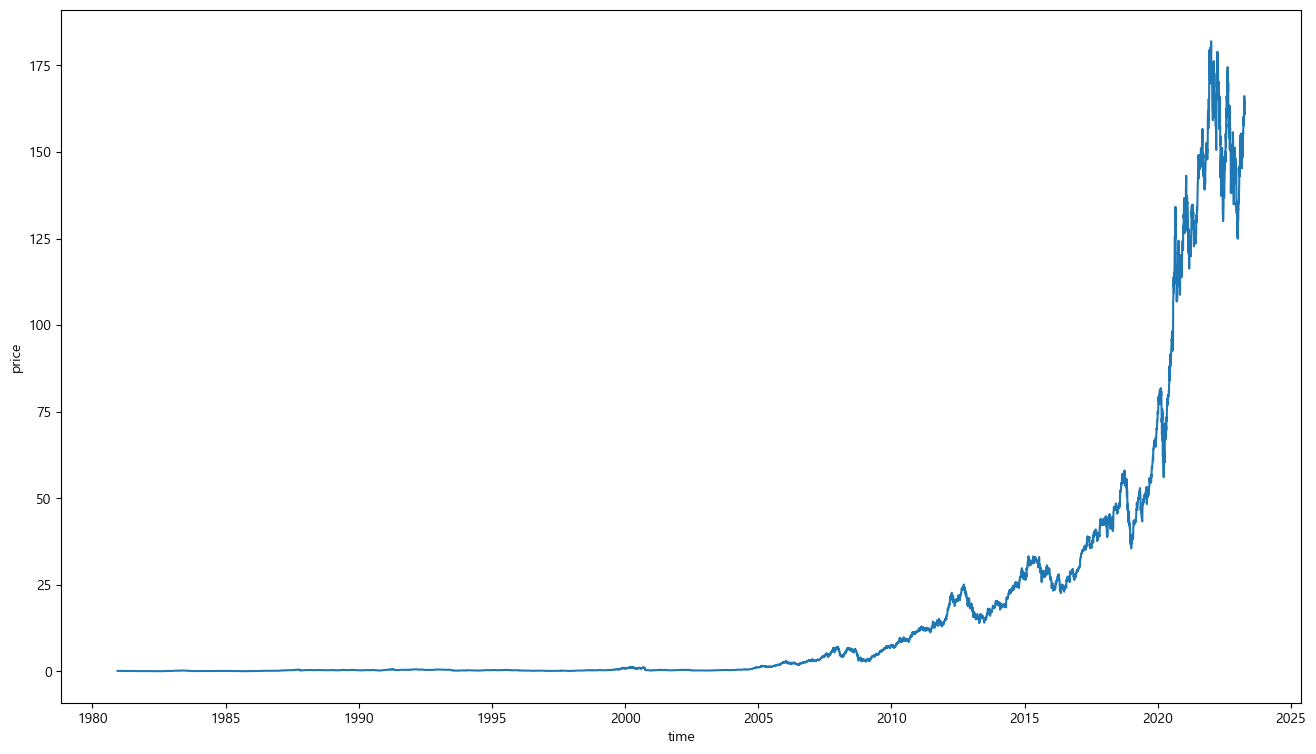

In [97]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=apple.index, y="Close", data=apple)
plt.xlabel("time")
plt.ylabel("price")
plt.show()

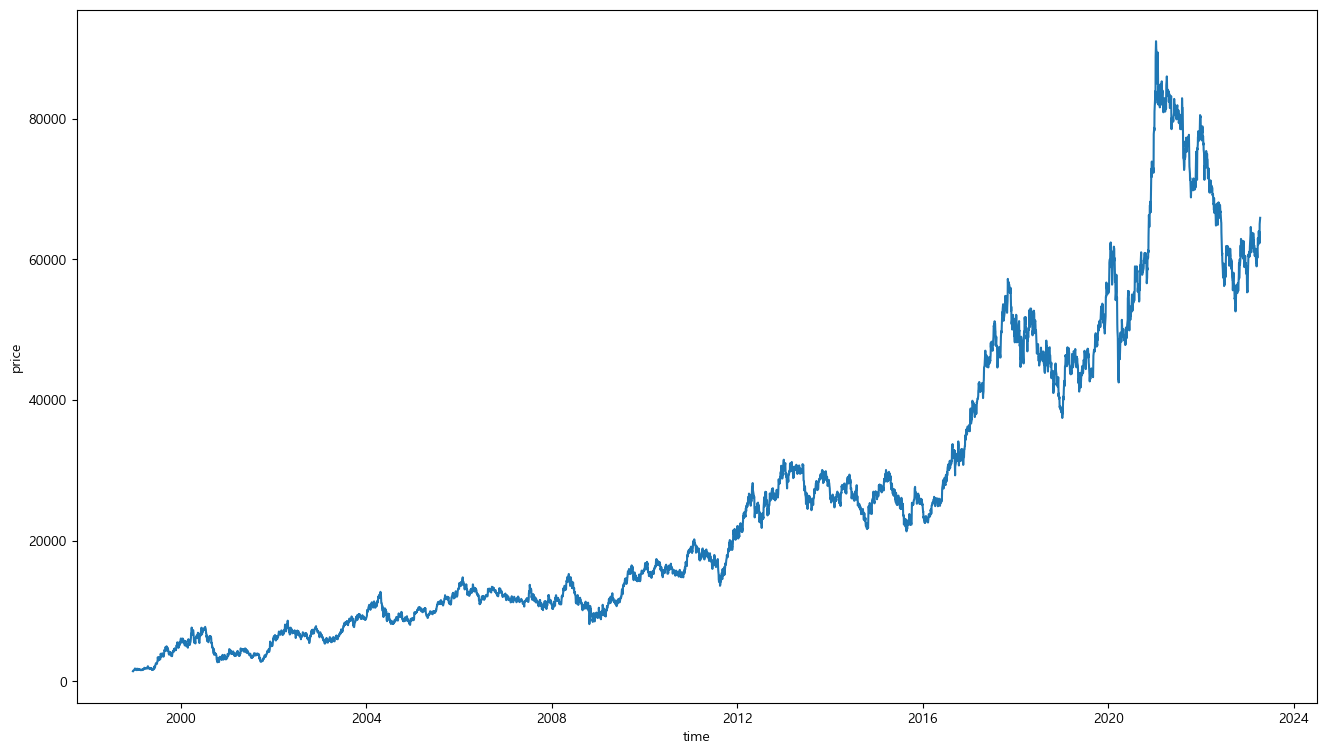

In [98]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=samsung.index, y="Close", data=samsung)
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [99]:
# 비트코인 시세
btc = fdr.DataReader("BTC/KRW", "2019-01-01", "2023-04-11")
btc.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-06,36979388.0,37723772.0,36616780.0,37116604.0,37116604.0,22461652857017
2023-04-07,37112976.0,37117132.0,36619020.0,36992692.0,36992692.0,18253290942742
2023-04-08,36985872.0,37072288.0,36606008.0,36759868.0,36759868.0,14297641772215
2023-04-09,36752828.0,37067896.0,36703960.0,36791596.0,36791596.0,12339328544076
2023-04-10,36797616.0,37585124.0,36634528.0,37299024.0,37299024.0,16028194560346


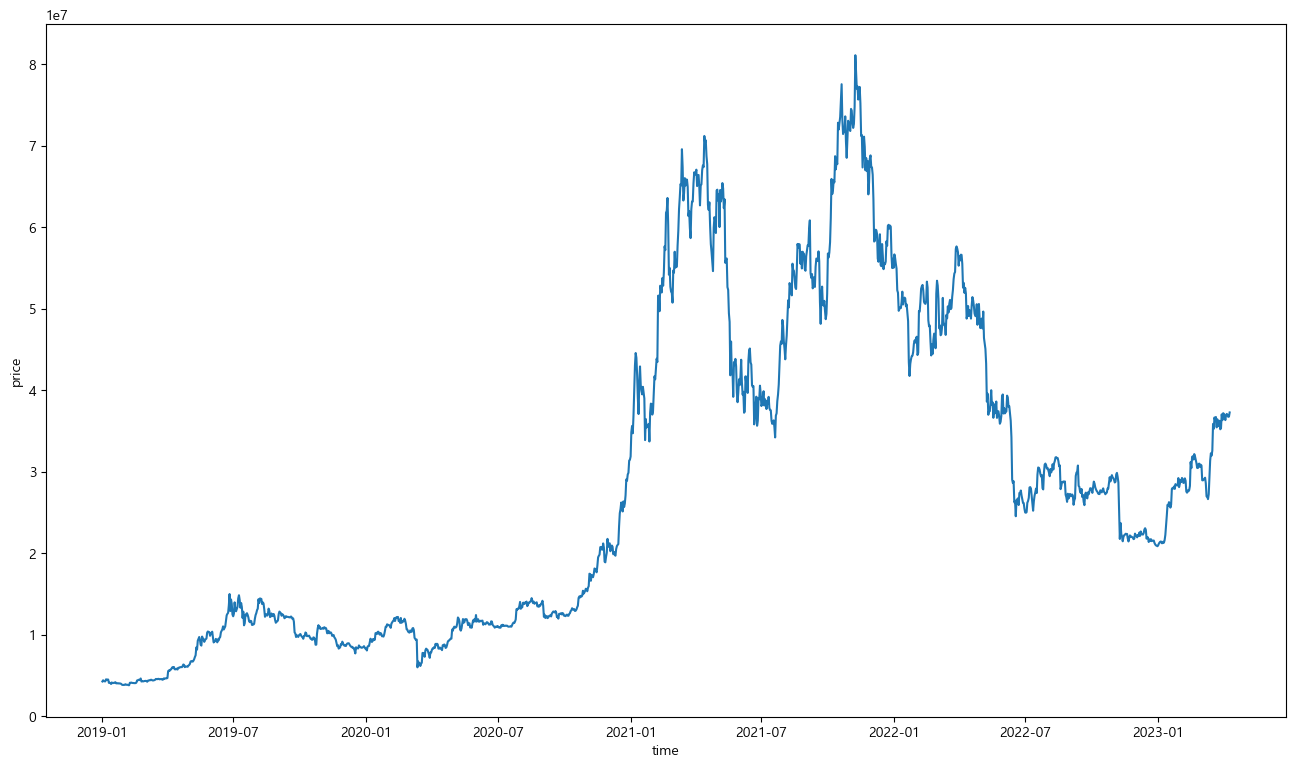

In [100]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=btc.index, y="Close", data=btc)
plt.xlabel("time")
plt.ylabel("price")
plt.show()

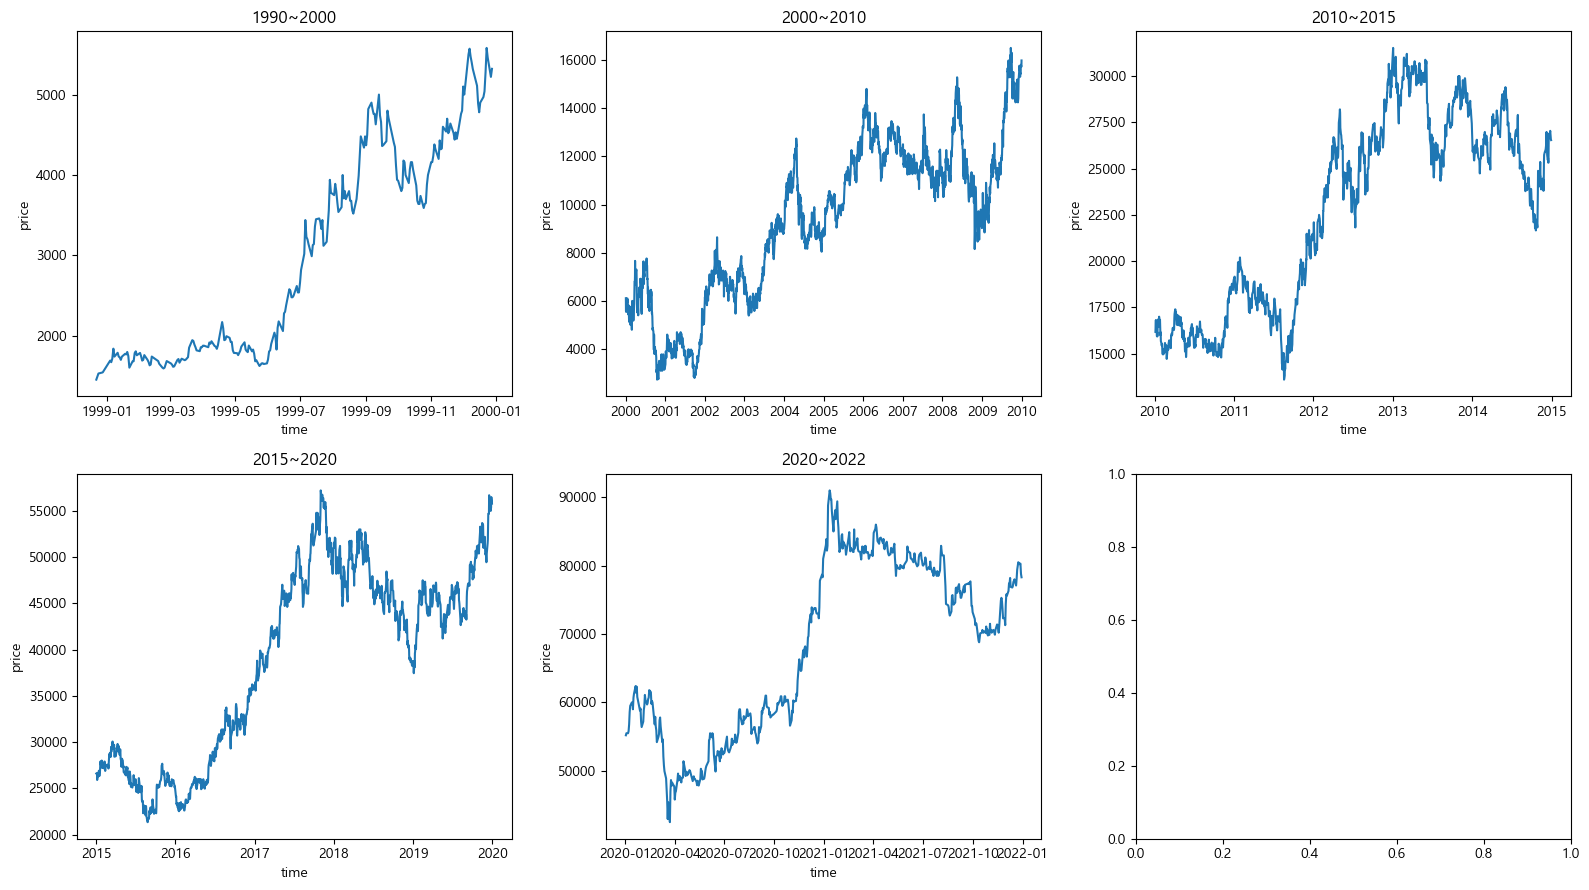

In [101]:
time_steps = [["1990", "2000"], 
              ["2000", "2010"], 
              ["2010", "2015"], 
              ["2015", "2020"],
              ["2020", "2022"]]

fig, axes = plt.subplots(2, 3)
fig.set_size_inches(16, 9)
for i in range(5):
    ax = axes[i//3, i%3]
    df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
    sns.lineplot(y=df["Close"], x=df.index, ax=ax)
    ax.set_title(f"{time_steps[i][0]}~{time_steps[i][1]}")
    ax.set_xlabel("time")
    ax.set_ylabel("price")
plt.tight_layout()
plt.show()

## 예제1) Prophet

In [102]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

- 반드시 **y** 컬럼과 **ds** 컬럼이 존재해야합니다.
- 예측 값은 **y**, 시계열 데이터는 **ds**에 지정합니다.

In [103]:
stock = fdr.DataReader("005930", "2022")
stock["y"] = stock["Close"]
stock["ds"] = stock.index
stock.head()

,Open,High,Low,Close,Volume,Change,y,ds
Date,,,,,,,,
2022-01-03,79400,79800,78200,78600,13502112,0.003831,78600,2022-01-03
2022-01-04,78800,79200,78300,78700,12427416,0.001272,78700,2022-01-04
2022-01-05,78800,79000,76400,77400,25470640,-0.016518,77400,2022-01-05
2022-01-06,76700,77600,76600,76900,12931954,-0.006460,76900,2022-01-06
2022-01-07,78100,78400,77400,78300,15163757,0.018205,78300,2022-01-07


### prophet 객체 선언 및 학습

In [104]:
m = Prophet()
m.fit(stock)

01:00:01 - cmdstanpy - INFO - Chain [1] start processing
01:00:01 - cmdstanpy - INFO - Chain [1] done processing


**period**에 예측 하고 싶은 기간을 입력 합니다. 예측할 시계열 row가 추가 됩니다. `periods`에 예측할 기간을 입력합니다.

In [105]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
340,2023-05-07
341,2023-05-08
342,2023-05-09
343,2023-05-10
344,2023-05-11


- `predict`로 예측을 진행합니다.
- `predict` 안에는 이전 단계에서 만들어준 future 데이터프레임을 입력합니다.


In [106]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
340,2023-05-07,63666.252919,61800.881291,66328.717182,63523.853659,63834.393615,340.745655,340.745655,340.745655,340.745655,340.745655,340.745655,0.0,0.0,0.0,64006.998574
341,2023-05-08,63691.508070,61402.370339,66126.964295,63539.496666,63869.640124,-100.753856,-100.753856,-100.753856,-100.753856,-100.753856,-100.753856,0.0,0.0,0.0,63590.754214
342,2023-05-09,63716.763220,61393.935295,66067.705337,63552.835911,63912.272630,-145.764714,-145.764714,-145.764714,-145.764714,-145.764714,-145.764714,0.0,0.0,0.0,63570.998506
343,2023-05-10,63742.018370,61279.724187,65981.030435,63567.416716,63953.210218,-195.061211,-195.061211,-195.061211,-195.061211,-195.061211,-195.061211,0.0,0.0,0.0,63546.957159
344,2023-05-11,63767.273520,61115.850490,66027.313721,63579.635839,63989.088321,-242.658246,-242.658246,-242.658246,-242.658246,-242.658246,-242.658246,0.0,0.0,0.0,63524.615274


In [107]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].iloc[-40:-20]

,ds,yhat,yhat_lower,yhat_upper
305,2023-03-29,62486.240854,60124.904023,64817.048966
306,2023-03-30,62463.898969,60081.367561,64823.956801
307,2023-03-31,62734.558913,60159.162891,64842.740296
308,2023-04-03,62706.823960,60418.908870,64968.675902
309,2023-04-04,62687.068252,60511.049301,64972.143772
310,2023-04-05,62663.026905,60305.779339,65055.600366
311,2023-04-06,62640.685020,60272.057171,64919.380377
312,2023-04-07,62911.344964,60504.447985,65267.191158
313,2023-04-10,62883.610011,60547.027299,65139.483480
314,2023-04-11,62863.854303,60399.437368,65117.783107


### 시각화

`plot`은 트렌드와 함께 예측된 결과물을 시각화하여 보여줍니다.

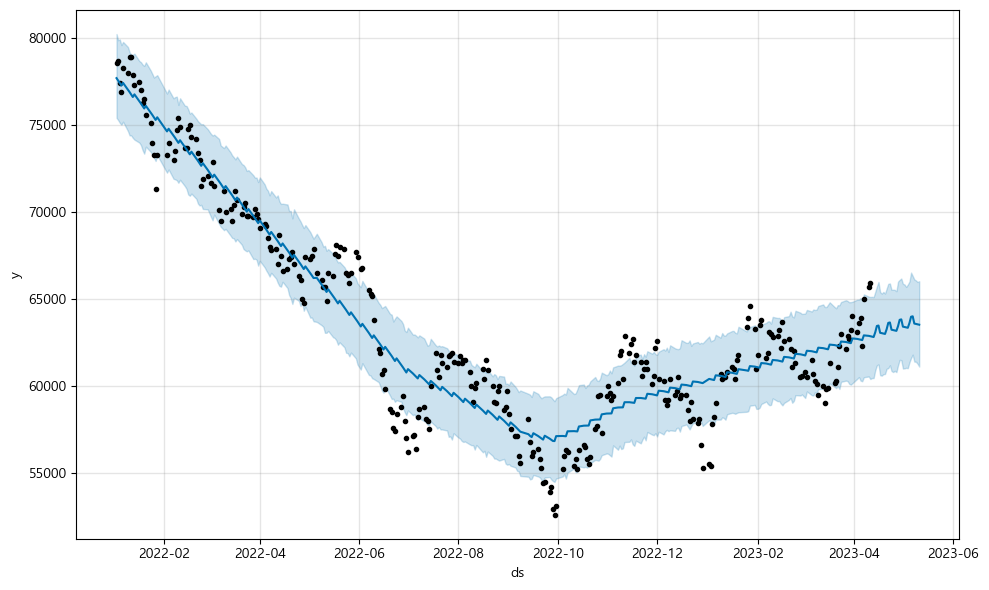

In [108]:
fig = m.plot(forecast)

### plotly 활용

In [109]:
fig = plot_plotly(m, forecast)
fig

### 컴포넌트 별 시각화

컴포넌트 별 시각화에서는 seasonality 별 시각화를 진행해 볼 수 있습니다. **trend, yearly, weekly 데이터를 시각화**하여 보여 줍니다.

In [110]:
plot_components_plotly(m, forecast)

### 변경점(changepoints)

- 처음 80%의 시계열 데이터에 대하여 잠재적인 25개의 changepoints를 만들고, 그 중 선별하여 최종 changepoints를 그래프에서 vertical line으로 그려주게 됩니다.

In [111]:
from prophet.plot import add_changepoints_to_plot

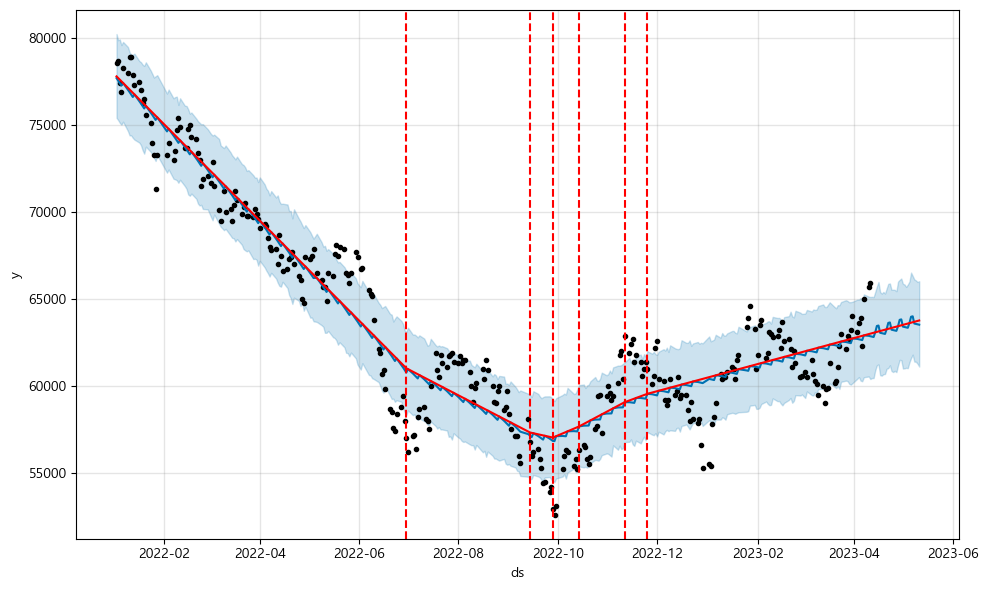

In [112]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### 유연성(flexibility) 조절

- flexibility **계수가 낮으면 과소적합, 높으면 과대적합**하여 예측하게 됩니다. 중요한 hyperparameter 입니다.

01:00:02 - cmdstanpy - INFO - Chain [1] start processing
01:00:02 - cmdstanpy - INFO - Chain [1] done processing


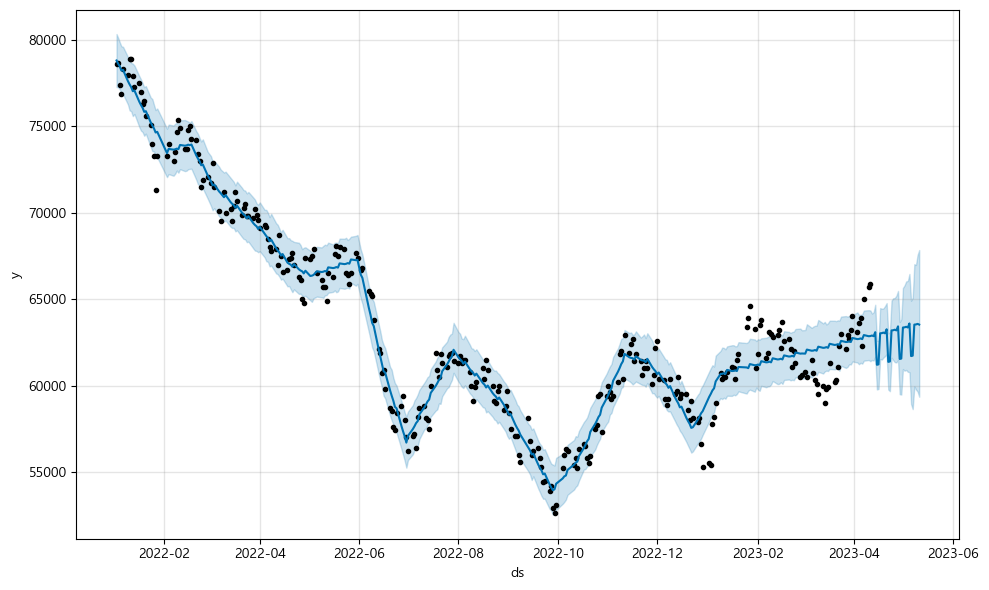

In [113]:
m = Prophet(changepoint_prior_scale=0.8)
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)

01:00:03 - cmdstanpy - INFO - Chain [1] start processing
01:00:03 - cmdstanpy - INFO - Chain [1] done processing


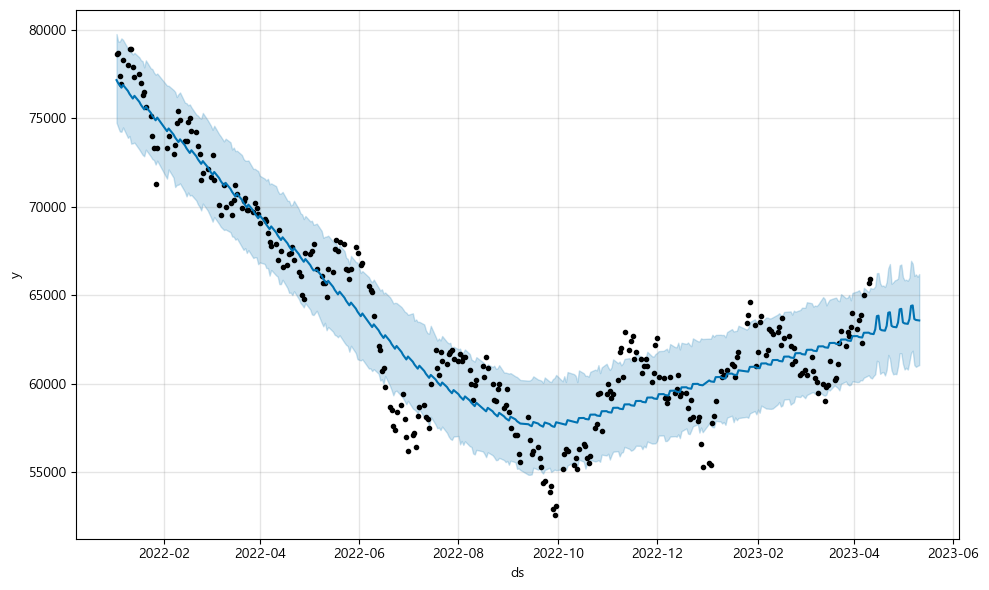

In [114]:
m = Prophet(changepoint_prior_scale=0.01)
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)

## 예제2) 서울시 코로나 확진자 현황

- [데이터셋 다운로드](http://data.seoul.go.kr/dataList/OA-20279/S/1/datasetView.do)

In [115]:
covid19 = pd.read_csv("../data/seoul_covid19.csv")

In [116]:
covid19.head()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,182558,2021-12-11,NaN,NaN,NaN,기타,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
1,182557,2021-12-11,NaN,NaN,NaN,성북구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
2,182556,2021-12-11,NaN,NaN,NaN,중구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
3,182555,2021-12-11,NaN,NaN,NaN,기타,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
4,182554,2021-12-11,NaN,NaN,NaN,광진구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y


In [117]:
covid19.tail()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
182553,5,2020-01-31,9.0,NaN,650909-1,성북구,NaN,기타 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182554,4,2020-01-30,7.0,NaN,561220-1,마포구,중국,해외유입,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182555,3,2020-01-30,6.0,NaN,810212-1,종로구,NaN,종로구 집단발병,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182556,2,2020-01-30,5.0,NaN,400415-1,중랑구,중국,해외유입,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182557,1,2020-01-24,2.0,NaN,600716-1,강서구,중국,해외유입,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y


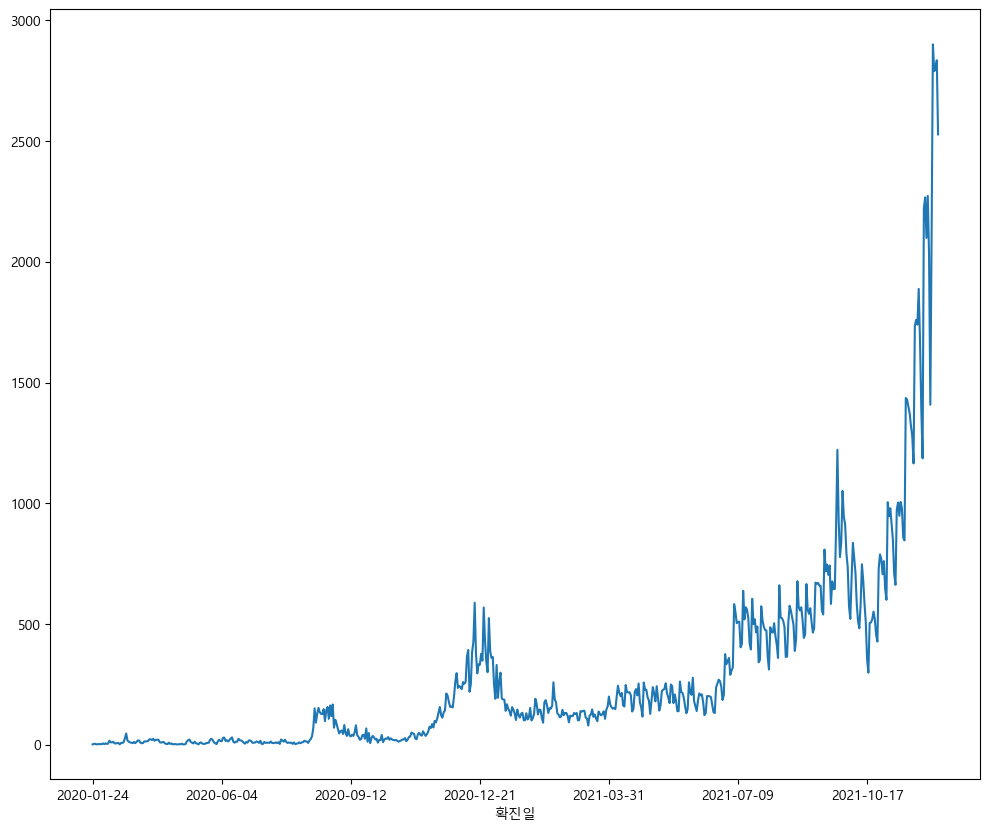

In [118]:
plt.figure(figsize=(12, 10))
covid19.groupby("확진일")["연번"].count().plot()
plt.show()

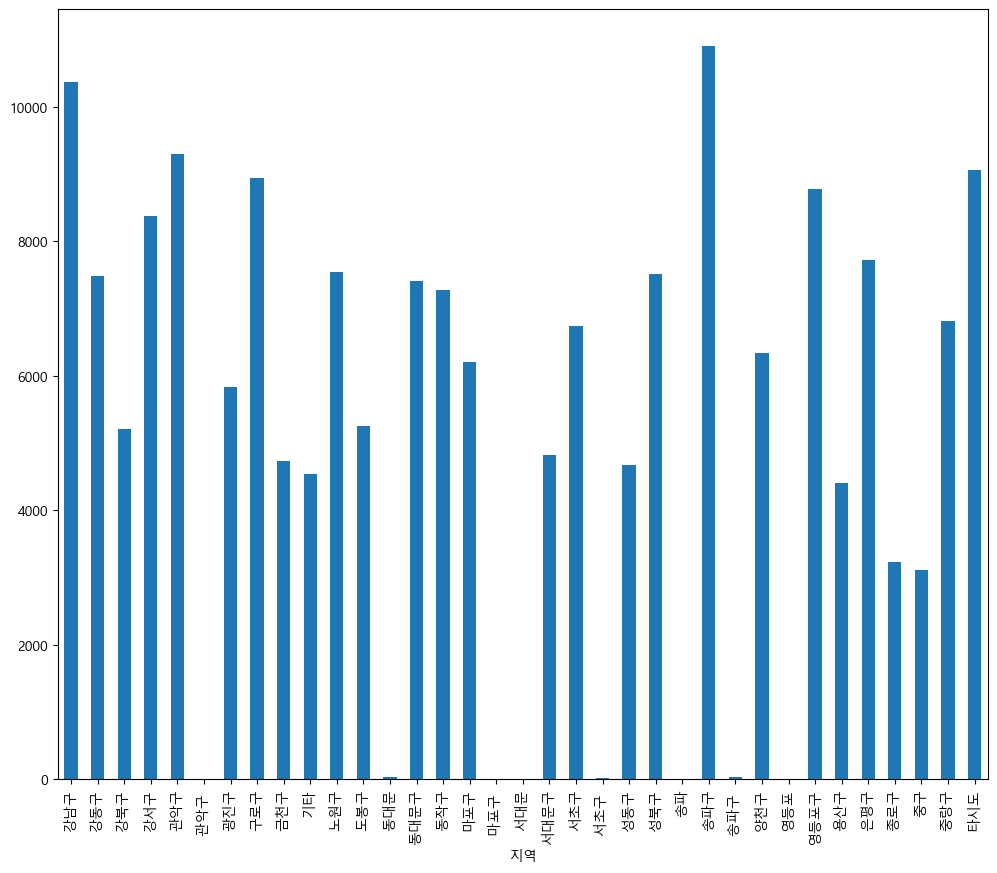

In [119]:
plt.figure(figsize=(12, 10))
covid19.groupby("지역")["연번"].count().plot(kind="bar")
plt.show()

### 정확한 분석을 위한 데이터 클린징

In [120]:
covid19.loc[covid19["지역"] == "관악구 "]

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
1428,181130,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
1464,181094,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
1774,180784,2021-12-11,NaN,NaN,NaN,관악구,NaN,기타 확진자 접촉,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
12155,170403,2021-12-07,NaN,NaN,NaN,관악구,NaN,기타 확진자 접촉,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y


In [121]:
covid19.loc[covid19["지역"] == "관악구"]

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
40,182518,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
51,182507,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
70,182488,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
91,182467,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
200,182358,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182440,118,2020-03-07,6845.0,NaN,510419-1,관악구,NaN,타시도 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182471,87,2020-02-29,3491.0,NaN,690602-1,관악구,NaN,타시도 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182484,74,2020-02-28,2466.0,NaN,700817-1,관악구,NaN,기타 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182505,53,2020-02-26,1295.0,NaN,800216-1,관악구,NaN,타시도 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y


In [122]:
covid19["지역"].apply(lambda x: x.strip())

0          기타
1         성북구
2          중구
3          기타
4         광진구
         ... 
182553    성북구
182554    마포구
182555    종로구
182556    중랑구
182557    강서구
Name: 지역, Length: 182558, dtype: object

In [123]:
covid19["지역"] = covid19["지역"].apply(lambda x: x.strip())

In [124]:
covid19.loc[covid19["지역"] == "관악구 "]

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부


**구**가 빠진 지역명은 구를 추가합니다.

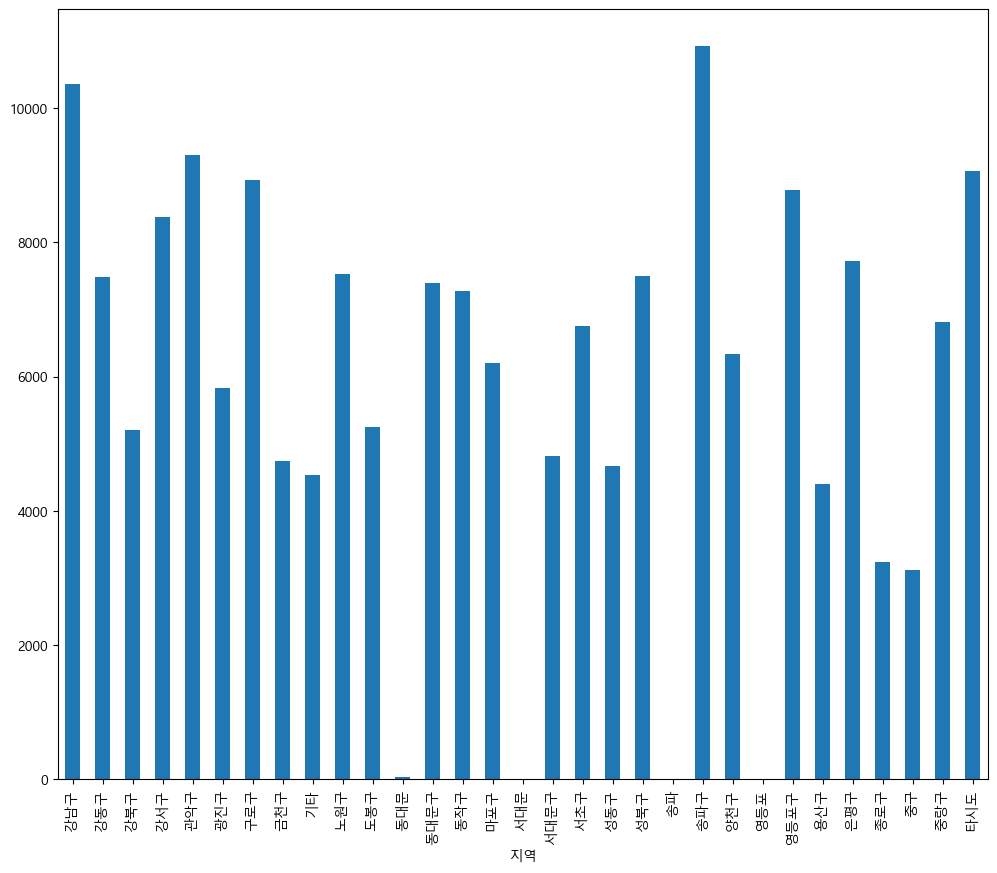

In [125]:
plt.figure(figsize=(12, 10))
covid19.groupby("지역")["연번"].count().plot(kind="bar")
plt.show()

In [126]:
target = ["동대문", "서대문", "송파", "영등포"]

In [127]:
covid19["지역"].apply(lambda x: x + "구" if x in target else x).value_counts()

지역
송파구     10932
강남구     10358
관악구      9300
타시도      9057
구로구      8932
영등포구     8779
강서구      8376
은평구      7721
노원구      7535
성북구      7504
강동구      7479
동대문구     7431
동작구      7273
중랑구      6815
서초구      6750
양천구      6341
마포구      6202
광진구      5826
도봉구      5251
강북구      5208
서대문구     4817
금천구      4735
성동구      4665
기타       4529
용산구      4399
종로구      3232
중구       3111
Name: count, dtype: int64

In [128]:
covid19["지역"] = covid19["지역"].apply(lambda x: x + "구" if x in target else x)

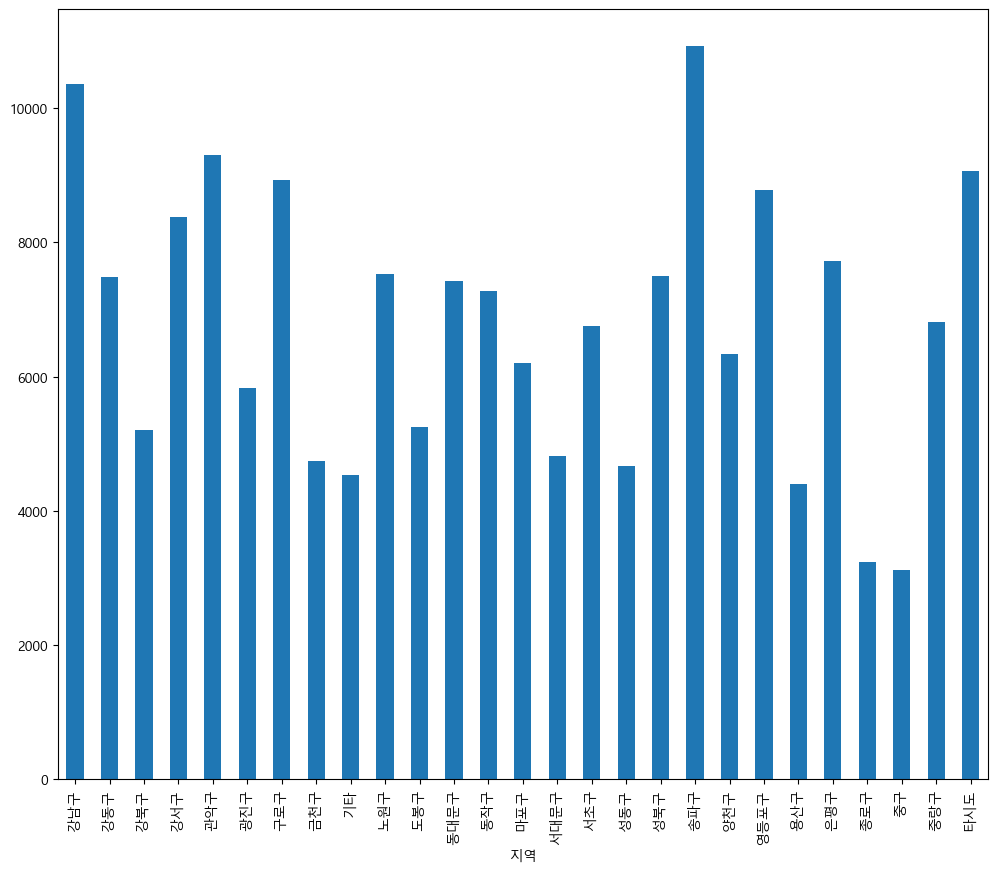

In [129]:
plt.figure(figsize=(12, 10))
covid19.groupby("지역")["연번"].count().plot(kind="bar")
plt.show()

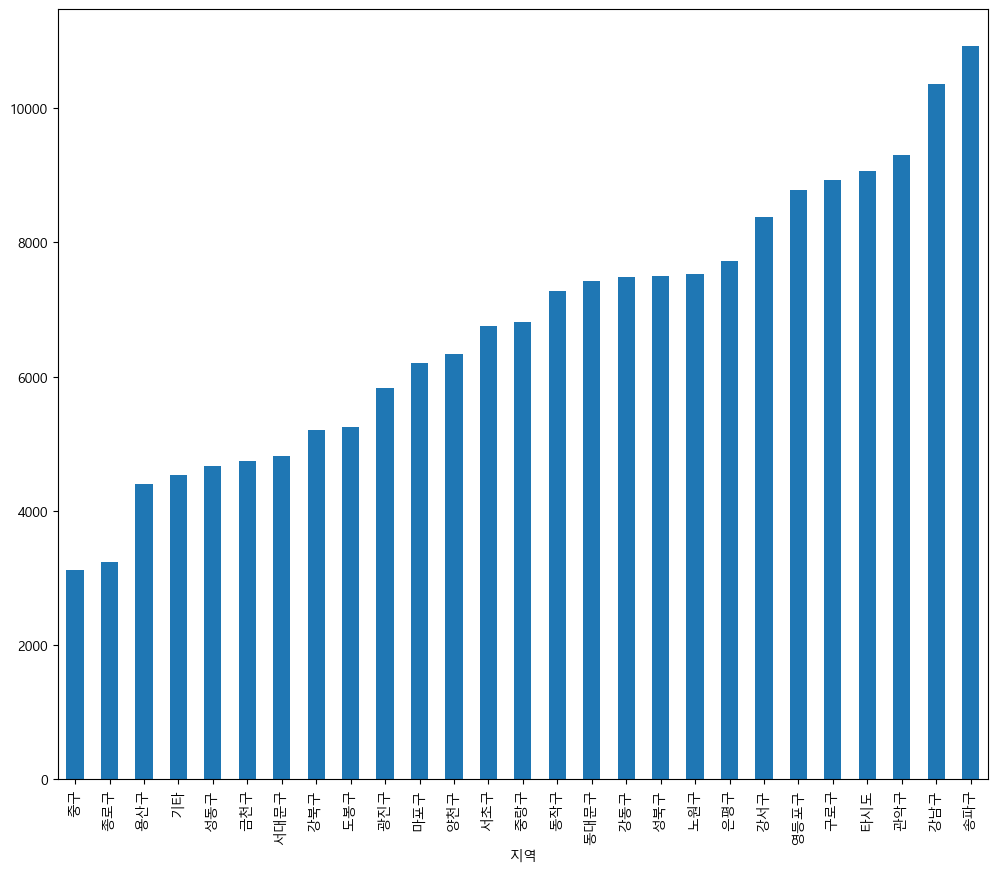

In [130]:
plt.figure(figsize=(12, 10))
covid19.groupby("지역")["연번"].count().sort_values().plot(kind="bar")
plt.show()

In [131]:
import requests
import json

In [132]:
covid19.head()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,182558,2021-12-11,NaN,NaN,NaN,기타,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
1,182557,2021-12-11,NaN,NaN,NaN,성북구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
2,182556,2021-12-11,NaN,NaN,NaN,중구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
3,182555,2021-12-11,NaN,NaN,NaN,기타,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
4,182554,2021-12-11,NaN,NaN,NaN,광진구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y


In [133]:
covid19_df = covid19.groupby("확진일")["연번"].count().reset_index()
covid19_df

,확진일,연번
0,2020-01-24,1
1,2020-01-30,3
2,2020-01-31,3
3,2020-02-02,1
4,2020-02-05,2
...,...,...
651,2021-12-07,2901
652,2021-12-08,2790
653,2021-12-09,2800
654,2021-12-10,2835


In [134]:
covid19_df.columns = ["ds", "y"]
covid19_df

,ds,y
0,2020-01-24,1
1,2020-01-30,3
2,2020-01-31,3
3,2020-02-02,1
4,2020-02-05,2
...,...,...
651,2021-12-07,2901
652,2021-12-08,2790
653,2021-12-09,2800
654,2021-12-10,2835


In [135]:
m = Prophet(changepoint_prior_scale=5.5, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m.fit(covid19_df)

01:00:05 - cmdstanpy - INFO - Chain [1] start processing
01:00:05 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
681,2022-01-06
682,2022-01-07
683,2022-01-08
684,2022-01-09
685,2022-01-10


In [137]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
681,2022-01-06,1858.542672,1619.181606,2152.593970,1750.693061,1943.944625,26.732947,26.732947,26.732947,26.732947,26.732947,26.732947,0.0,0.0,0.0,1885.275619
682,2022-01-07,1868.984611,1634.668300,2144.459221,1752.818969,1959.270767,22.622283,22.622283,22.622283,22.622283,22.622283,22.622283,0.0,0.0,0.0,1891.606894
683,2022-01-08,1879.426551,1606.051785,2135.590074,1754.516345,1975.100061,-3.265350,-3.265350,-3.265350,-3.265350,-3.265350,-3.265350,0.0,0.0,0.0,1876.161200
684,2022-01-09,1889.868490,1555.582803,2097.735576,1758.627826,1992.443285,-59.649361,-59.649361,-59.649361,-59.649361,-59.649361,-59.649361,0.0,0.0,0.0,1830.219129
685,2022-01-10,1900.310430,1559.639243,2119.034291,1763.226660,2008.831251,-55.978834,-55.978834,-55.978834,-55.978834,-55.978834,-55.978834,0.0,0.0,0.0,1844.331596


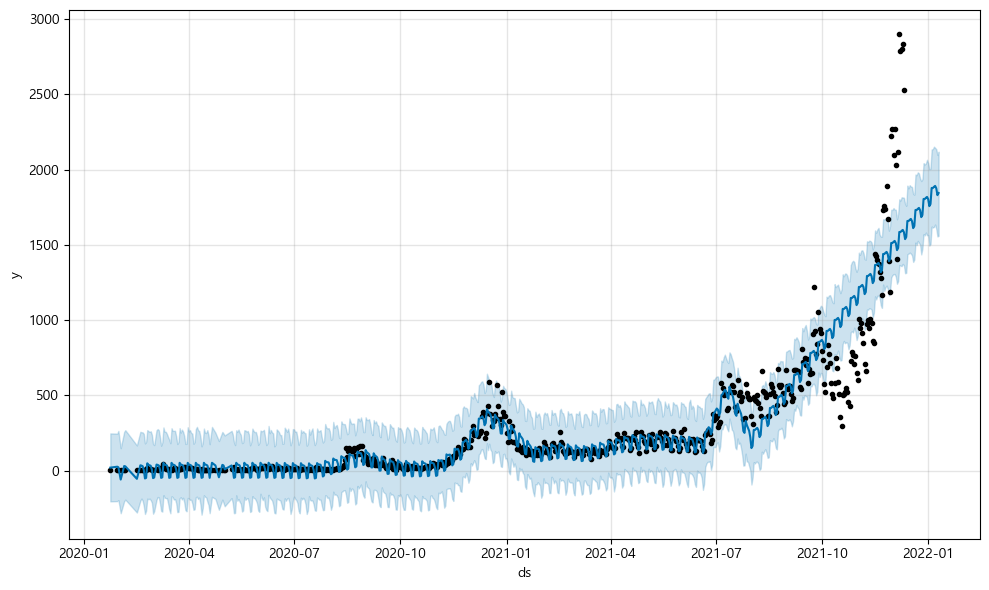

In [138]:
fig = m.plot(forecast)

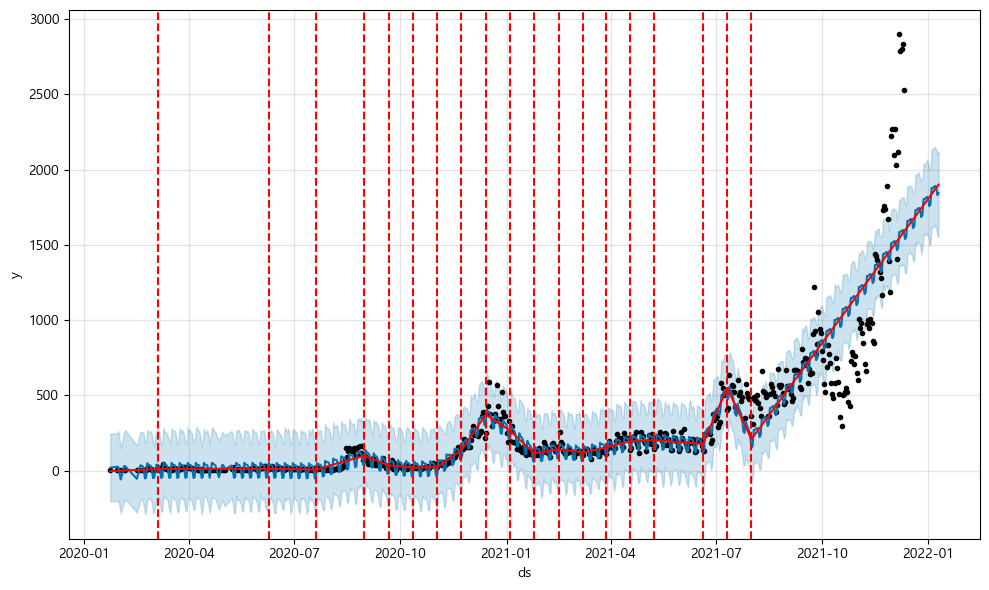

In [139]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

01:00:06 - cmdstanpy - INFO - Chain [1] start processing
01:00:06 - cmdstanpy - INFO - Chain [1] done processing


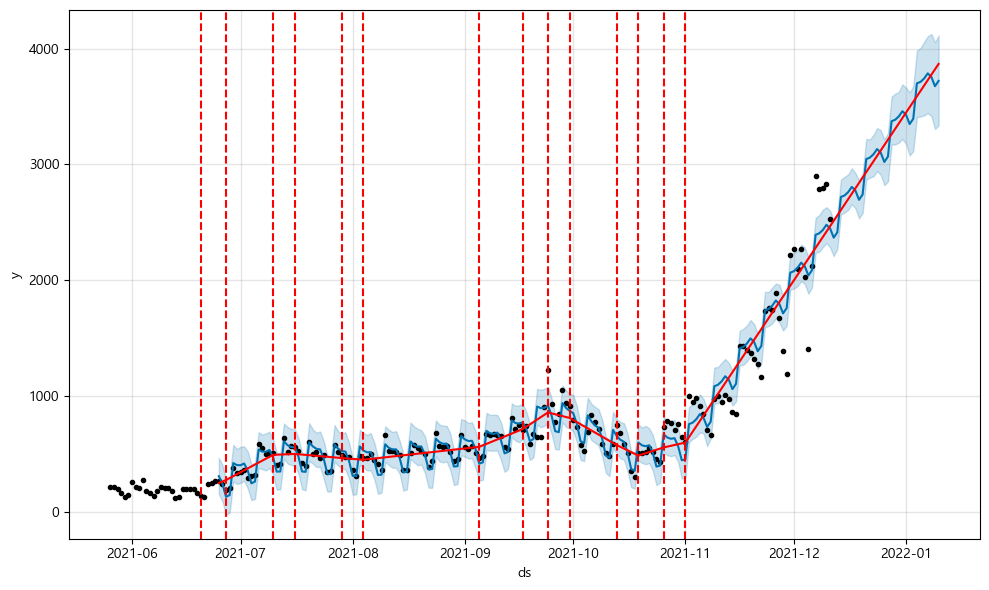

In [140]:
# 최근 N일 데이터로 시뮬레이션 결과
N = 200
m = Prophet(changepoint_prior_scale=1.5, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
forecast = m.fit(covid19_df.iloc[-N:]).predict(future.iloc[-N:])
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

01:00:06 - cmdstanpy - INFO - Chain [1] start processing
01:00:06 - cmdstanpy - INFO - Chain [1] done processing


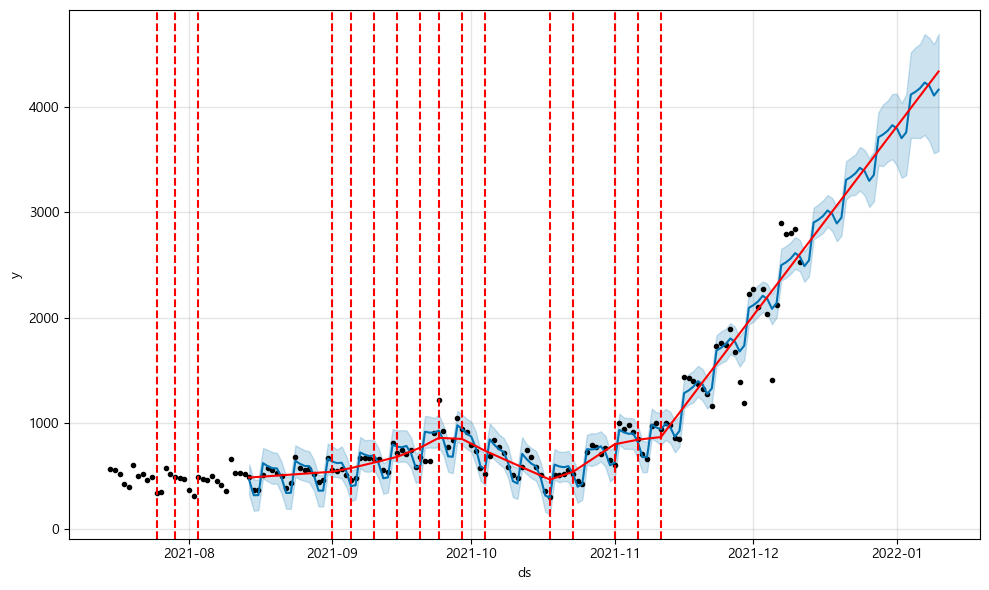

In [141]:
# 최근 N일 데이터로 시뮬레이션 결과
N = 150
m = Prophet(changepoint_prior_scale=1.5, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
forecast = m.fit(covid19_df.iloc[-N:]).predict(future.iloc[-N:])
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

01:00:07 - cmdstanpy - INFO - Chain [1] start processing
01:00:07 - cmdstanpy - INFO - Chain [1] done processing


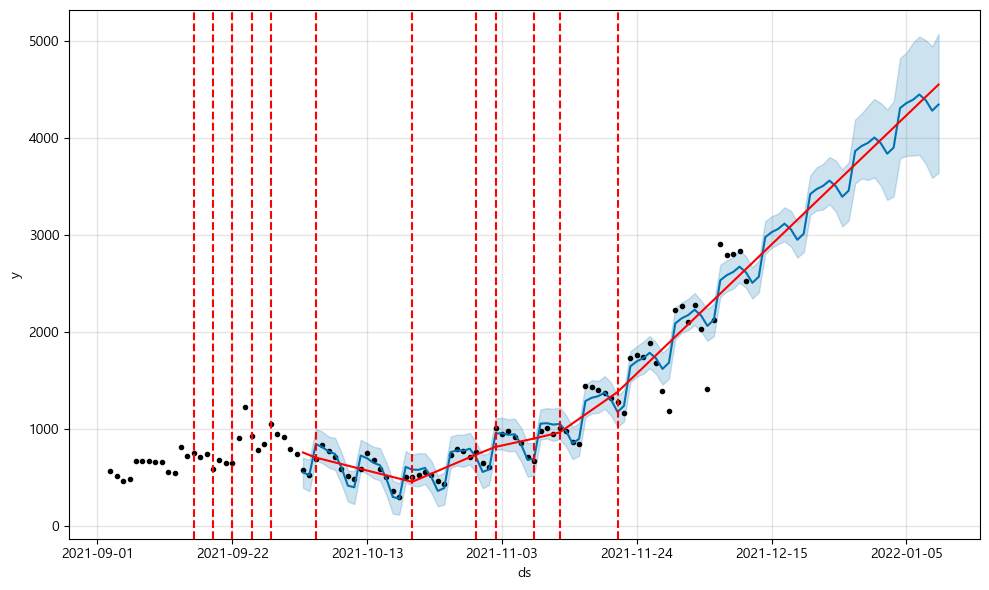

In [142]:
# 최근 N일 데이터로 시뮬레이션 결과
N = 100
m = Prophet(changepoint_prior_scale=1.5, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
forecast = m.fit(covid19_df.iloc[-N:]).predict(future.iloc[-N:])
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)